In [38]:
# -*- coding: utf-8 -*
import twitter
import csv
import json
import re
import requests
import lxml.html as html
from urllib2 import urlopen
import pandas as pd
from datetime import datetime, timedelta
from dateutil import tz
import time
import sklearn.cross_validation as cv
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [39]:
PREPARED_CSV = "prepared_to_analys.csv"
df = pd.read_csv(PREPARED_CSV, sep=",")

In [40]:
# Удаляем лишние столбцы
major_features = ["url", "week_day_news", "minutes_since_midnight", "first_time_tweet","follower_sum", "retweeted_count_sum", "favorite_count_sum", "user_listed_count_sum", "last_time_tweet"]
df = df[major_features]

In [41]:
# С глубоким прискорбием удаляем NA - если ничего не было, пока не будем будмать, что могло быть
df = df.drop_duplicates().dropna()

In [42]:
# В итоге имеем:
len(df)

407

In [43]:
df.head(1)

,url,week_day_news,minutes_since_midnight,first_time_tweet,follower_sum,retweeted_count_sum,favorite_count_sum,user_listed_count_sum,last_time_tweet
62,https://tjournal.ru/p/peking-duk-fan,5,1145,4,252956,40,38,1198,35


In [44]:
x = df[df.columns[1:-1]].as_matrix()
y = df[df.columns[-1]].as_matrix()

In [45]:
# Делим данные
x_train, x_test, y_train, y_test = cv.train_test_split(x, y, test_size=0.2)

In [46]:
print "Коэффициенты корреляции Y:"
for i in range(len(major_features)-2):
    print major_features[i+1], "=", np.corrcoef(x[:,i], y)[0][1]

Коэффициенты корреляции Y:
week_day_news = 0.564968364601
minutes_since_midnight = -0.151646897311
first_time_tweet = 0.560682072978
follower_sum = 0.249691390779
retweeted_count_sum = 0.156571629208
favorite_count_sum = -0.108698922401
user_listed_count_sum = 0.249408320415


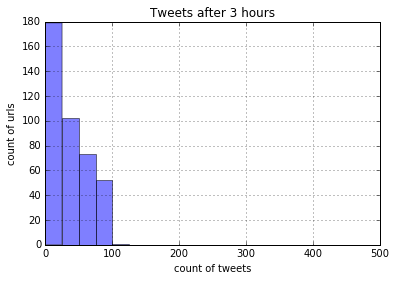

In [47]:
df.last_time_tweet.hist(alpha=0.5, bins=[i*25 for i in range(20)])
plt.title("Tweets after 3 hours")
plt.ylabel("count of urls")
plt.xlabel("count of tweets")
plt.show()

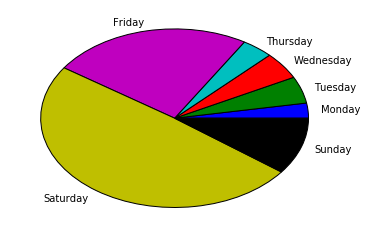

In [48]:
#df.week_day_news.hist(alpha=0.5, bins=[i for i in range(7)])
S = df.groupby("week_day_news")["last_time_tweet"].sum()
plt.pie(S.as_matrix(), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);
plt.show();

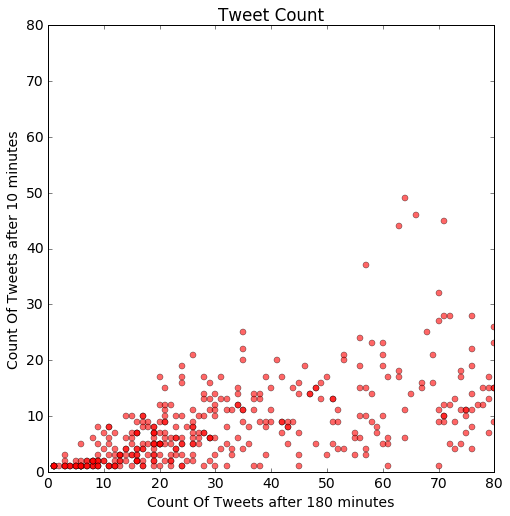

In [49]:
plt.figure(figsize=(8,8))
plt.plot(df["last_time_tweet"].as_matrix(), df["first_time_tweet"].as_matrix(), 'ro',  alpha=0.6)
plt.title("Tweet Count")
plt.xlabel("Count Of Tweets after 180 minutes")
plt.ylabel("Count Of Tweets after 10 minutes")
plt.xlim(0, 80)
plt.ylim(0, 80)
#plt.xscale('log')
#plt.yscale('log')
#plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.rcParams.update({'font.size': 14})

In [50]:
df[df["last_time_tweet"]> 50]

,url,week_day_news,minutes_since_midnight,first_time_tweet,follower_sum,retweeted_count_sum,favorite_count_sum,user_listed_count_sum,last_time_tweet
860,http://lifenews.ru/news/173668,6,369,37,646198,21,17,4659,57
1072,http://lifenews.ru/news/173660,6,270,44,687946,22,12,4711,63
1143,http://lifenews.ru/news/173659,6,257,13,11862,0,0,163,51
1343,http://lifenews.ru/news/173652,6,197,49,657467,17,4,4756,64
1803,http://lifenews.ru/news/173646,6,35,6,533847,17,1,3164,55
1956,http://lifenews.ru/news/173641,5,1427,45,683348,20,5,4717,71
2029,http://lifenews.ru/news/173637,5,1382,10,1067491,21,4,6334,60
2164,http://lifenews.ru/news/173634,5,1337,1,532302,58,6,3120,99
2364,http://lifenews.ru/news/173632,5,1314,26,556392,55,13,3525,82
2450,http://lifenews.ru/news/173630,5,1303,23,578911,59,12,3511,81


In [17]:
df[df["last_time_tweet"]> 25][["first_time_tweet", "last_time_tweet"]]

,first_time_tweet,last_time_tweet
62,4,35
242,1,28
897,14,45
971,8,26
1068,11,35
1129,10,28
1239,3,57
1520,11,52
1616,11,32
1903,1,45


In [51]:
def plot(y_test, y_predicted,title="", text=""):
    plt.figure(figsize=(9,9))
    plt.plot(y_test, y_predicted, 'ro', label="predicted", alpha=0.7)
    plt.title(title)
    plt.xlabel("Y_TEST")
    plt.ylabel("Y_PREDICTED")
    
    max_y = max(max(y_true), max(y_predicted))+10
    
    plt.xlim(0, max_y)
    plt.ylim(0, max_y)
    #plt.legend()
    plt.text(0.05*max_y, max_y-0.05*max_y, "mse="+text, fontsize=15)
    
    plt.plot([0, max_y], [0, max_y], color='black', alpha=0.5)
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
    
    plt.show()

In [52]:
def split_data(train_index, test_index):
    x_train = x[train_index]
    y_train = y[train_index]
    
    x_test = x[test_index]
    y_test = y[test_index]
    
    return x_train, x_test, y_train, y_test

In [53]:
loo = cv.LeaveOneOut(len(y))

## Деревья

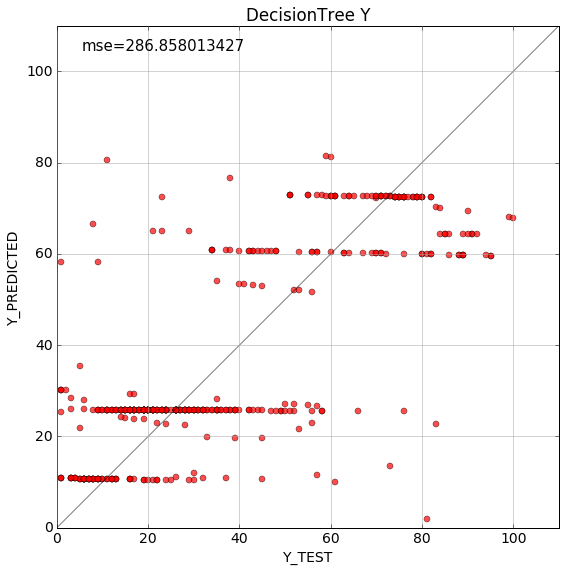

In [54]:
from sklearn.tree import DecisionTreeRegressor

y_predicted = []
y_true = []

for train_index, test_index in loo:
    x_train, x_test, y_train, y_test = split_data(train_index, test_index)
    dtree = DecisionTreeRegressor(max_depth=3)
    dtree.fit(x_train, y_train)
    y_pred = dtree.predict(x_test[0])
    y_predicted.append(y_pred[0])
    y_true.append(y_test[0])
    

mse = mean_squared_error(y_true, y_predicted)
plot(y_true, y_predicted, title="DecisionTree Y", text=str(mse))

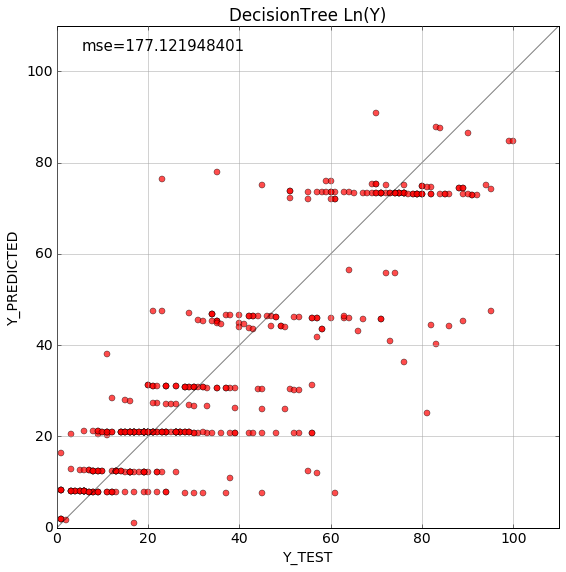

In [55]:
from sklearn.tree import DecisionTreeRegressor

y_predicted = []
y_true = []


for train_index, test_index in loo:
    x_train, x_test, y_train, y_test = split_data(train_index, test_index)
    dtree = DecisionTreeRegressor(max_depth=4)
    dtree.fit(x_train, np.log(y_train))
    y_pred = dtree.predict(x_test[0])
    y_predicted.append(np.exp(y_pred[0]))
    y_true.append(y_test[0])

mse = mean_squared_error(y_true, y_predicted)
plot(y_true, y_predicted, title="DecisionTree Ln(Y)", text=str(mse))

В целом, конечно, дерево решений работает плохо, но выбросы оно вполне себе улавливает

In [56]:
y_true = np.asarray(y_true)
y_predicted = np.asarray(y_predicted)
BIG = 100
y_big_true = y_true[y_true>BIG]
y_big_predicted = y_predicted[y_true>BIG]

In [57]:
a = pd.DataFrame([y_big_true, y_big_predicted])
a.index=["y_true","y_predicted"]
a

""
y_true
y_predicted


Вопрос к Михаилу.

Как замерять RandomForest и другие рандомные методы. Раз через раз дает катастрофическую разницу. 400!

In [58]:
df.reset_index(inplace=True)

In [59]:
predic = pd.Series(np.around(y_predicted))

In [60]:
df["DT_Predict"]=predic
df_LTT = df[["url", "last_time_tweet", "DT_Predict"]]
df_LTT[df_LTT["last_time_tweet"]>70]

,url,last_time_tweet,DT_Predict
30,http://lifenews.ru/news/173641,71,46
34,http://lifenews.ru/news/173634,99,85
35,http://lifenews.ru/news/173632,82,75
36,http://lifenews.ru/news/173630,81,75
37,http://lifenews.ru/news/173628,88,74
38,http://lifenews.ru/news/173622,89,45
39,http://lifenews.ru/news/173616,76,75
40,http://lifenews.ru/news/173619,89,74
41,http://lifenews.ru/news/173614,83,88
44,http://lifenews.ru/news/173606,95,47


### LinearRegression

In [61]:
from sklearn.linear_model import Ridge

Подбираем параметр

In [62]:
alpha = [0.01, 0.1, 1, 10, 1e2, 1e3, 1e4, 1e5, 2e5, 4e5, 8e5, 1e6, 2e6, 4e6, 7e6, 1e7, 1e8]

mse = []
for al in alpha:
    y_predicted = []
    y_true = []

    for train_index, test_index in loo:
        x_train, x_test, y_train, y_test = split_data(train_index, test_index)
        model = Ridge(alpha=al)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test[0])
        y_predicted.append(y_pred[0])
        y_true.append(y_test[0])
    
    cur_mse = mean_squared_error(y_true, y_predicted)
    print cur_mse
    mse.append(cur_mse)

best_alpha = alpha[mse.index(min(mse))]
print "Best Aplha = ", best_alpha
#plot(y_true, y_predicted, title="DecisionTree Log(Y)")

373.802429066
373.802244371
373.800534963
373.796800778
374.773936885
397.762959064
450.81336622
551.448875052
576.927953637
595.49668411
607.62977347
610.412040245
616.453651449
619.73686308
621.200493253
621.826839051
626.458134308
Best Aplha =  10


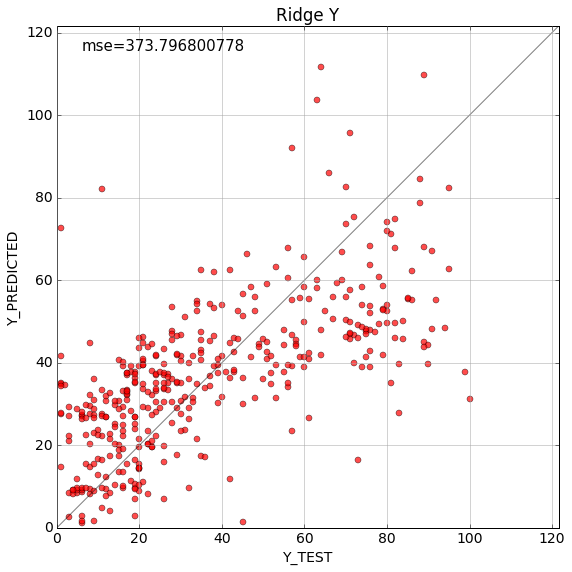

[  6.29431271e+00  -1.83697158e-03   1.44539788e+00  -6.54032999e-08
   2.00148247e-01  -3.71875163e-02  -1.49490976e-03]


In [63]:
y_predicted = []
y_true = []

for train_index, test_index in loo:
    x_train, x_test, y_train, y_test = split_data(train_index, test_index)
    model = Ridge(alpha=best_alpha)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test[0])
    y_predicted.append(y_pred[0])
    y_true.append(y_test[0])

mse = mean_squared_error(y_true, y_predicted)
plot(y_true, y_predicted, title="Ridge Y", text=str(mse))
print model.coef_

Теперь логарифм

In [64]:
alpha = [0.01, 0.1, 1, 10, 1e2, 1e3, 1e4, 1e5, 2e5, 4e5, 8e5, 1e6, 2e6, 4e6, 7e6, 1e7, 1e8]

mse = []
for al in alpha:
    y_predicted = []
    y_true = []

    for train_index, test_index in loo:
        x_train, x_test, y_train, y_test = split_data(train_index, test_index)
        model = Ridge(alpha=al)
        model.fit(x_train, np.log(y_train))
        y_pred = model.predict(x_test[0])
        y_predicted.append(np.exp(y_pred[0]))
        y_true.append(y_test[0])

    cur_mse = mean_squared_error(y_true, y_predicted)
    print cur_mse
    mse.append(cur_mse)


best_alpha = alpha[mse.index(min(mse))]
print "Best Aplha = ", best_alpha
#plot(y_true, y_predicted, title="DecisionTree Log(Y)")

1229.97498158
1230.03361208
1230.61897891
1236.37964197
1285.45891289
1365.543399
699.428675403
647.725182088
671.476066713
687.773882095
697.812070862
700.057716032
704.909854052
707.598789442
708.861322149
709.420632728
711.594969809
Best Aplha =  100000.0


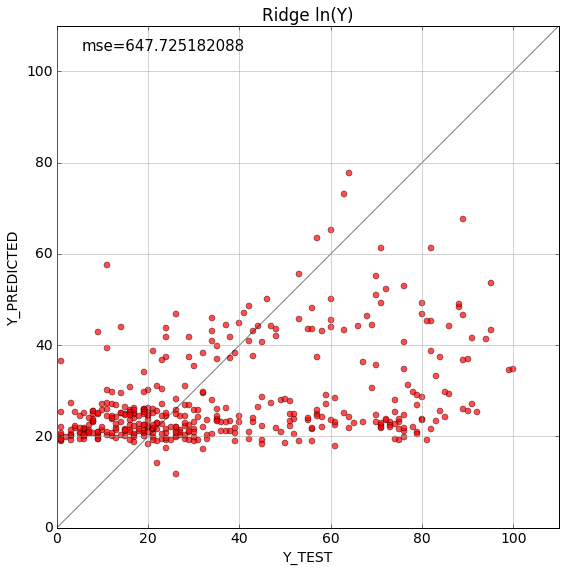

[  2.17334322e-03  -1.71315250e-04   9.69356123e-03   7.46478097e-07
   1.72277671e-03  -3.39550009e-03   5.49572298e-05]


In [65]:
y_predicted = []
y_true = []

for train_index, test_index in loo:
    x_train, x_test, y_train, y_test = split_data(train_index, test_index)
    model = Ridge(alpha=best_alpha)
    model.fit(x_train, np.log(y_train))
    y_pred = model.predict(x_test[0])
    y_predicted.append(np.exp(y_pred[0]))
    y_true.append(y_test[0])
    
mse = mean_squared_error(y_true, y_predicted)
plot(y_true, y_predicted, title="Ridge ln(Y)", text=str(mse))
print model.coef_

# RandomForest 

In [66]:
from sklearn.ensemble import RandomForestRegressor

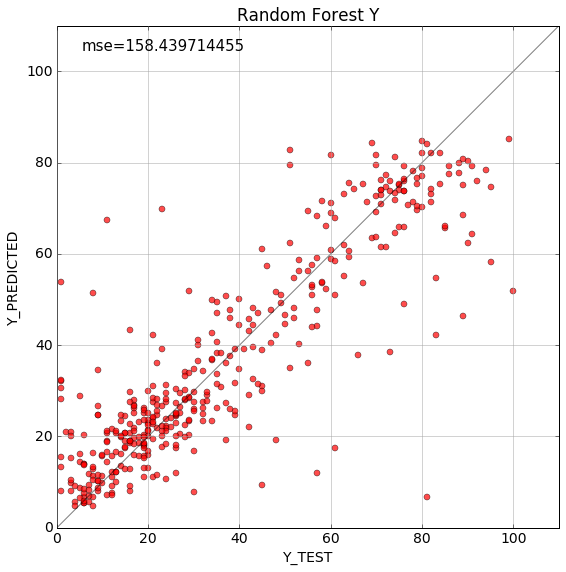

In [67]:
y_predicted = []
y_true = []

for train_index, test_index in loo:
    x_train, x_test, y_train, y_test = split_data(train_index, test_index)
    model = RandomForestRegressor(n_estimators=20)
    model.fit(x_train, (y_train))
    y_pred = model.predict(x_test[0])
    y_predicted.append((y_pred[0]))
    y_true.append(y_test[0])

mse = mean_squared_error(y_true, y_predicted)
plot(y_true, y_predicted, title="Random Forest Y", text=str(mse))

#### Теперь логарифм

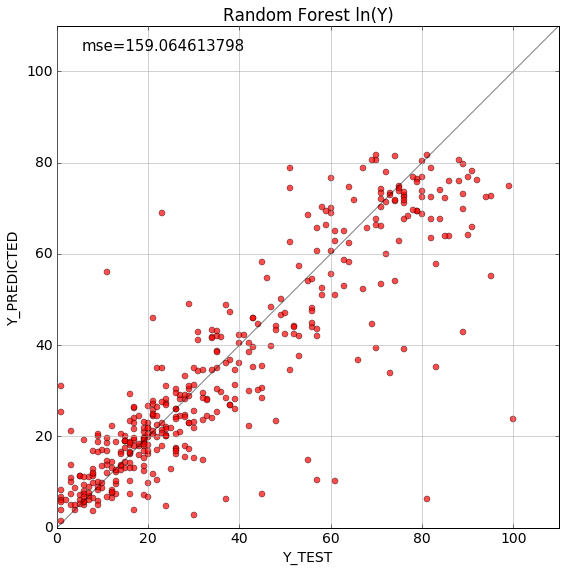

In [68]:
y_predicted = []
y_true = []

for train_index, test_index in loo:
    x_train, x_test, y_train, y_test = split_data(train_index, test_index)
    model = RandomForestRegressor(n_estimators=50)
    model.fit(x_train, np.log(y_train))
    y_pred = model.predict(x_test[0])
    y_predicted.append(np.exp(y_pred[0]))
    y_true.append(y_test[0])

mse = mean_squared_error(y_true, y_predicted)
plot(y_true, y_predicted, title="Random Forest ln(Y)", text=str(mse))

In [37]:
predic = pd.Series(np.around(y_predicted))
df["predicted"]=predic
d = df.sort_values("last_time_tweet", ascending=False)
d[["url", "last_time_tweet", "predicted"]].head(20)

,url,last_time_tweet,predicted
95,https://tjournal.ru/p/condomchallenge,83,39
104,https://tjournal.ru/p/automate-everything,73,39
56,https://tjournal.ru/p/rkn-no-enemy-of-the-state,59,26
23,https://tjournal.ru/p/putin-federal-message-2015,57,10
40,https://tjournal.ru/p/papa-rap,56,43
106,https://tjournal.ru/p/fuboy-epic-trolling,53,59
59,https://vc.ru/n/cards-money,52,9
30,https://tjournal.ru/p/pills-grey-or-red-and-blue,52,49
37,https://vc.ru/p/solar-power,45,8
13,https://tjournal.ru/p/chemezov-putin-uchebnik-...,45,38


## Проверка

In [34]:
df = pd.read_csv(PREPARED_CSV, sep=",")
df = df[["url", "week_day_news", "minutes_since_midnight", "first_time_tweet","follower_sum", "retweeted_count_sum", "favorite_count_sum", "user_listed_count_sum", "last_time_tweet", "views", "comments"]]
df = df.drop_duplicates().dropna()
df = df.reset_index()

In [35]:
ltt = df["last_time_tweet"].as_matrix()
comments = df["comments"].as_matrix()
views = df["views"].as_matrix()

In [36]:
np.corrcoef(views, ltt)

array([[ 1.        ,  0.39176351],
       [ 0.39176351,  1.        ]])

In [37]:
np.corrcoef(comments, ltt)

array([[ 1.       ,  0.3524211],
       [ 0.3524211,  1.       ]])

In [38]:
np.corrcoef(views, comments)

array([[ 1.        ,  0.65061814],
       [ 0.65061814,  1.        ]])

In [39]:
m = np.mean(comments)

In [40]:
np.corrcoef(views*np.exp(comments*0.5/m), ltt)

array([[ 1.        ,  0.28837992],
       [ 0.28837992,  1.        ]])

In [333]:
df = pd.read_csv(PREPARED_CSV, sep=",")
df = df[["url", "week_day_news", "minutes_since_midnight", "first_time_tweet","follower_sum", "retweeted_count_sum", "favorite_count_sum", "user_listed_count_sum", "last_time_tweet", "views", "comments"]]
df = df.drop_duplicates().dropna()
df = df.reset_index()
ltt = df["last_time_tweet"].as_matrix()
comments = df["comments"].as_matrix()
views = df["views"].as_matrix()

In [367]:
def plot(y_test, y_predicted, labelX, labelY):
    plt.figure(figsize=(9,9))
    plt.plot(y_test, y_predicted, 'ro', label="predicted", alpha=0.7)
    #plt.title(title)
    plt.xlabel(labelX)
    plt.ylabel(labelY)

    #max_y = max(max(y_true), max(y_predicted))+10

    #plt.xlim(0, max_y)
    #plt.ylim(0, max_y)
    plt.xscale('log')
    plt.yscale('log')
    #plt.legend()
    #plt.text(0.05*max_y, max_y-0.05*max_y, "mse="+text, fontsize=15)

    #plt.plot([0, max_y], [0, max_y], color='black', alpha=0.5)
    #plt.grid(b=True, which='both', color='0.65',linestyle='-')

    plt.show()

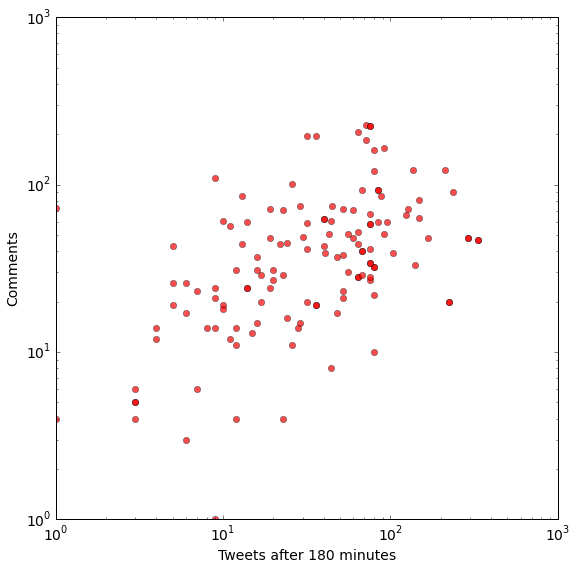

In [368]:
plot(ltt, comments, "Tweets after 180 minutes", "Comments")

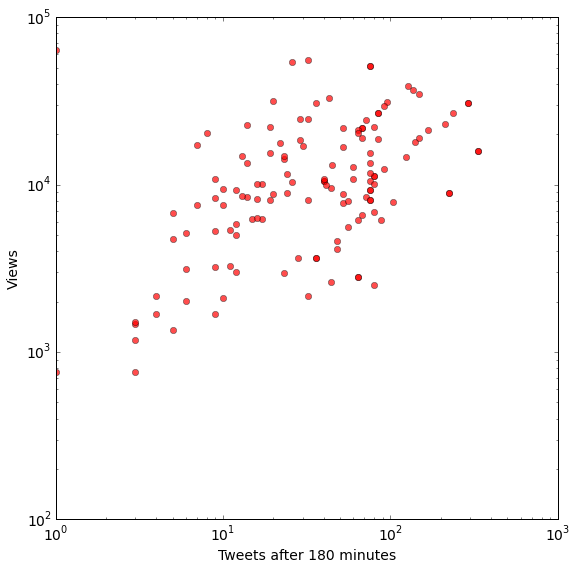

In [362]:
#plot(ltt, views, "Tweets after 180 minutes", "Views")
plt.figure(figsize=(9,9))
plt.plot(ltt, views, 'ro', label="predicted", alpha=0.7)
#plt.title(title)
plt.xlabel("Tweets after 180 minutes")
plt.ylabel("Views")
plt.xscale('log')
plt.yscale('log')
#max_y = max(max(y_true), max(y_predicted))+10
#plt.xlim(0, max_y)
#plt.ylim(0, max_y)
#plt.legend()
#plt.text(0.05*max_y, max_y-0.05*max_y, "mse="+text, fontsize=15)

#plt.plot([0, max_y], [0, max_y], color='black', alpha=0.5)
#plt.grid(b=True, which='both', color='0.65',linestyle='-')

plt.show()

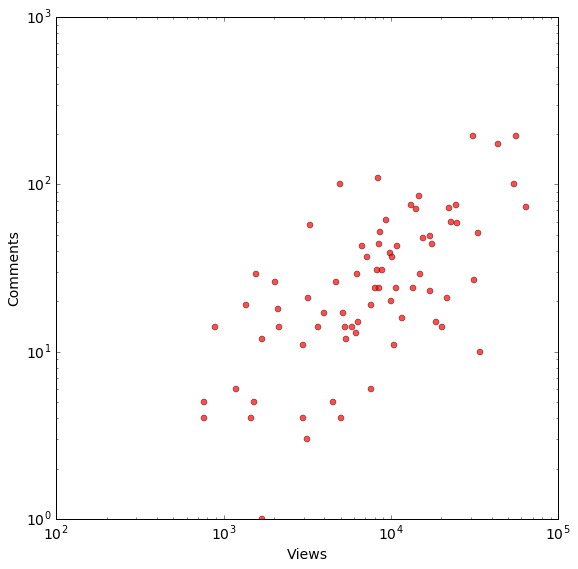

In [41]:
#plot(views, comments, "Views", "Comments")
#plot(ltt, views, "Tweets after 180 minutes", "Views")
plt.figure(figsize=(9,9))
plt.plot(views, comments, 'ro', label="predicted", alpha=0.7)
#plt.title(title)
plt.xlabel("Views")
plt.ylabel("Comments")
plt.xscale('log')
plt.yscale('log')
#max_y = max(max(y_true), max(y_predicted))+10
#plt.xlim(0, max_y)
#plt.ylim(0, max_y)
#plt.legend()
#plt.text(0.05*max_y, max_y-0.05*max_y, "mse="+text, fontsize=15)

#plt.plot([0, max_y], [0, max_y], color='black', alpha=0.5)
#plt.grid(b=True, which='both', color='0.65',linestyle='-')

plt.show()